# Bias Variance Tradeoff

In [50]:
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn import linear_model
from sklearn import preprocessing

from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.optimize import curve_fit

import numpy as np
import pandas as pd
import graphviz
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

## Introduction

This notebook sumamrize some basic ideas in modern data science, and draws from publically available data sets in scikit-learn to illustrate these ideas. To this point, these models all seek to explain the concept of bais-variance tradeoff. Bias-variance tradeoff deals with model complexity. Let's say you have the following dataset:

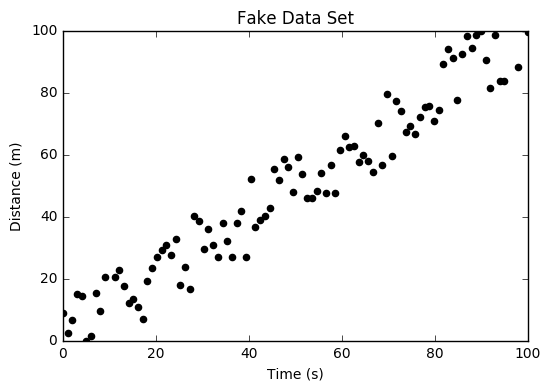

In [52]:
#Generate Linear Data with Noise
x = np.linspace(0,100,100)
y = np.linspace(0,100,100)+25*(np.random.rand(100)-0.5)

#Plot Data
plt.scatter(x,y,color="black")
plt.axis([0,100,0,100])
plt.title("Fake Data Set")
plt.xlabel("Time (s)")
plt.ylabel("Distance (m)")

In this case, the correct model is obvious. There is a linear relationship between distance and time traveled, so we would fit this data to a line. However, let's say the model isn't known. The solution set of models is infinite, but let's say we fit this data to a linear model - and an nth order polynomial. Using the same loss function (l2 loss), we would get the following results:
$$ L2 = \sum_n (y_n - f(x_n))^2.$$

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:14: RankWarning: Polyfit may be poorly conditioned


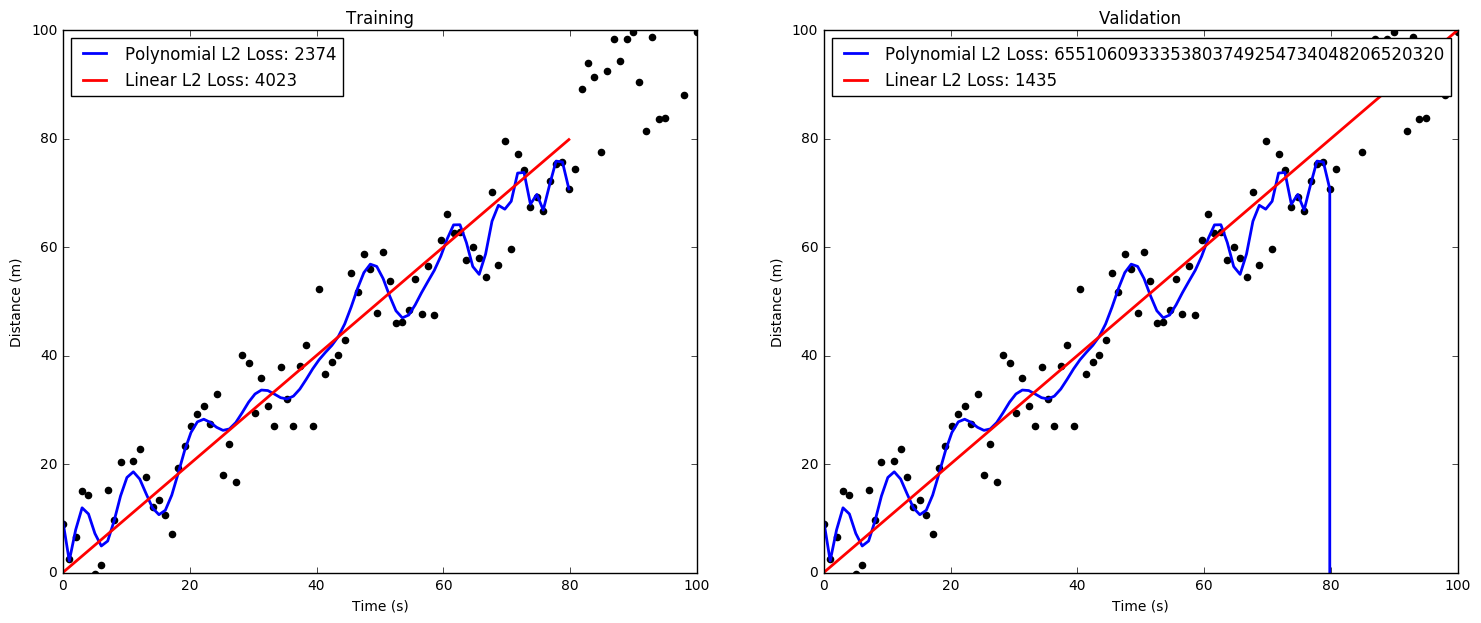

In [78]:
# @hidden_cell
#Models
# Linear
x_train,y_train = x[:80],y[:80]
x_test,y_test = x[80:],y[80:]
model1 = linear_model.LinearRegression()
model1.fit(zip(x_train,y_train),x_train)
m,b = model1.coef_
check1 = m*x_train+b
l2_lin = np.sum((check1-y_train)**2)
l2_str = "Linear L2 Loss: "+str(int(l2_lin))

#Polynomial
z = np.poly1d(np.polyfit(x_train,y_train,150))
l2_poly = np.sum((z(x_train)-y_train)**2)
l2_str2 = "Polynomial L2 Loss: "+str(int(l2_poly))

#Validation
lin_check_val = m*x_test+b
l2_lin_val = np.sum((lin_check_val-y_test)**2)
l2_val_str = "Linear L2 Loss: "+str(int(l2_lin_val))
poly_check_val = z(x_test)
l2_poly_val = np.sum((poly_check_val-y_test)**2)
l2_val_str2 = "Polynomial L2 Loss: "+str(int(l2_poly_val))

#Plots
f, ax = plt.subplots(figsize=(18, 7))
#Train
plt.subplot(1,2,1)
plt.plot(x_train,z(x_train),color='blue',linewidth=2,label=l2_str2)
plt.plot(x_train,check1,color='red',linewidth=2,label=l2_str)
plt.scatter(x,y,color="black")
plt.axis([0,100,0,100])
plt.title("Training")
plt.xlabel("Time (s)")
plt.ylabel("Distance (m)")
plt.legend(loc=2)

#Test
plt.subplot(1,2,2)
plt.plot(x,z(x),color='blue',linewidth=2,label=l2_val_str2)
plt.plot(x,m*x+b,color='red',linewidth=2,label=l2_val_str)
plt.scatter(x,y,color="black")
plt.axis([0,100,0,100])
plt.title("Validation")
plt.xlabel("Time (s)")
plt.ylabel("Distance (m)")
plt.legend(loc=2)

The models above, particularly the polynomial model, have some issues. Specifically, the polynomial model has a lower l2 loss during training, but fails to generalize on the Validation Set. This can be seen by the astronomical l2 loss of the polynomical model in the second plot. 
$$ $$
The linear model, on the other hand, suffers from high l2 loss in general. The polynomial model overfits the data, and the linear model underfits the data. Another way to state this is that the polynomial model has high variance, and the linear model has high bias. 
$$ $$
In data science, we want to find a model that balances bias and variance. In this example, we generated the data and knew the correct model ahead of time. In real world problems, this is obviously not the case. The correct model is not known, so we hypothesize that the correct model can be represented by the technique that optimizes bias and variance.
$$ Error = \epsilon_{irreducible} + bias^2 + variance $$
1. $\epsilon_{irreducible}$ is the irreducible error associated with statistical fluctuations in the data
2. bias is the error in the model due to too little complexity
3. variance is the error in the model due to too much complexity
<img src="complexity.png">
Source: https://elitedatascience.com/bias-variance-tradeoff

## Feature Selection - Correlations 

For this notebook, we'll use a publically available dataset in sklearn. Specifically the breast cancer dataset, which includes 30 fields with 569 records. Each record maps to one of two classes - either cancerous or non-cancerous. This labeled data set will allow us to easily investigate various supervised techniques using multiple models.

In [81]:
# Get Data
def get_cancer_data():
    cancer = datasets.load_breast_cancer()
    data = cancer.data
    labels = cancer.target
    pd_data = pd.DataFrame(data= cancer.data,
                     columns= cancer.feature_names)
    return cancer,data,labels

In [82]:
# Retrieve Data
cancer,X,Y = get_cancer_data()
X-= X.mean(axis=0)
X/=X.std(axis=0)

First we want to generate summary statistics for our data. One interesting property to look at would be the correlation between each field amongst all records. There, are many ways to do this, although two common ones are the Pearson coefficient and the Spearman coefficient. While they are similar, there is an important distinction between them.

The Pearson coefficient is defined as:
$$\rho_{X,Y} = \frac{cov(X,Y)}{\sigma_X \sigma_Y},$$
<ol>
<li>cov(X,Y): The covariance of X and Y, defined as $\frac{1}{N}\sum_{i=j}(X_i-\mu_X) \cdot (Y_j-\mu_Y)$</li>
<li> $\sigma_X,\sigma_Y$: The standard deviation of the random variables</li>
</ol>

It some cases, the user will have already scaled the input by the standard deviation. Moreover, it is common that the data has been zero-centered during pre-processing. As a result, computing the Pearson coefficient is often as simple as: 
$$cov_XY=X.T.dot(X)/float(len(X)),$$
which should generate an NxN matrix, where N represents the number of fields (which in this case would be 30).

The Spearman coefficient has a similar definition; however, the Spearman coefficient is 1 whenever X and Y are related by ANY monotonic function. This can be advantageous over the Pearson coefficient, which specifically looks for linear relationships. 

I often like to look at both coefficients. Below I've defined two methods that compute the Pearson and Spearman coefficients and plot them. The follow block executes these methods.

In [5]:
def get_pearson(X,num_fields=4):
    # Get Matrix
    mat = np.zeros((num_fields,num_fields))
    for row in range(num_fields):
        for col in range(num_fields):
            mat[row,col] = pearsonr(X[:,row],X[:,col])[0]
    #Plot Matrix
    f, ax = plt.subplots(figsize=(18, 15))
    plt.title('Pearson Correlation',size=20)
    sns.heatmap(np.round(mat,2),linewidths=0.25,vmax=1.0, square=True, 
            cmap="YlGnBu", linecolor='black', annot=True)
    return mat

def get_spearman(X,num_fields=4):
    mat = np.zeros((num_fields,num_fields))
    for row in range(num_fields):
        for col in range(num_fields):
            mat[row,col] = spearmanr(X[:,row],X[:,col])[0]
    #Plot Matrix
    f, ax = plt.subplots(figsize=(18, 15))
    plt.title('Spearman Correlation',size=20)
    sns.heatmap(np.round(mat,2),linewidths=0.25,vmax=1.0, square=True, 
            cmap="YlGnBu", linecolor='black', annot=True)
    return mat

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


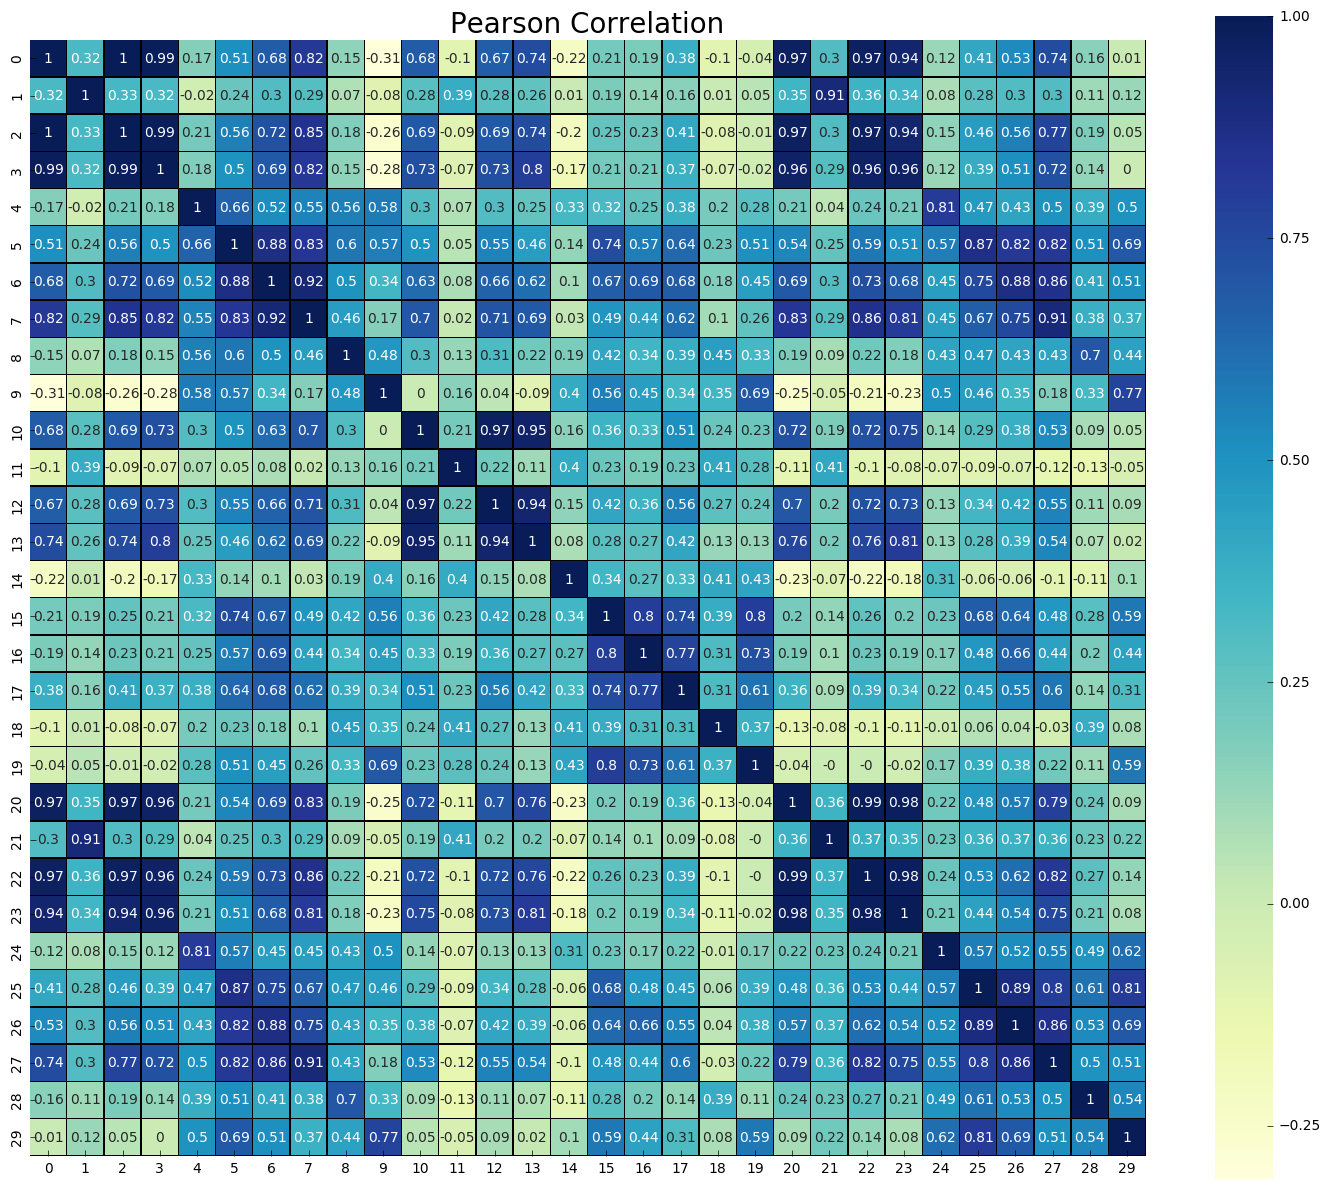

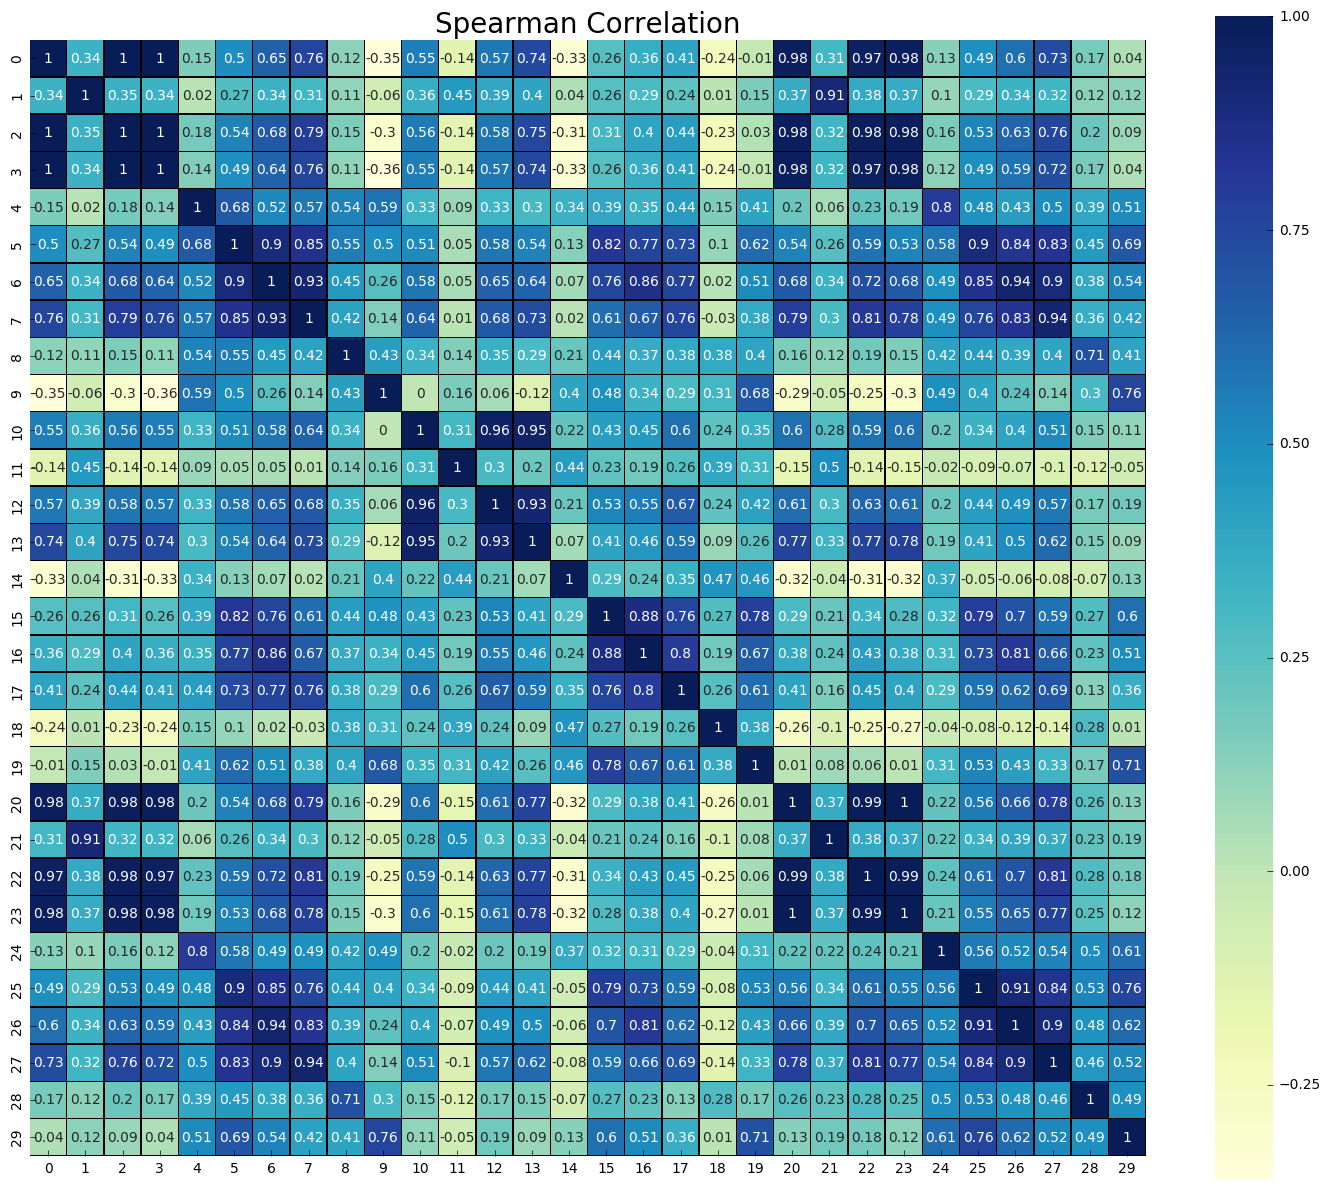

In [6]:
print(cancer.feature_names)
pearson_mat = get_pearson(X,num_fields=len(cancer.feature_names))
spearman_mat = get_spearman(X,num_fields=len(cancer.feature_names))

Cancer Scatter Plots - Left Quadrant


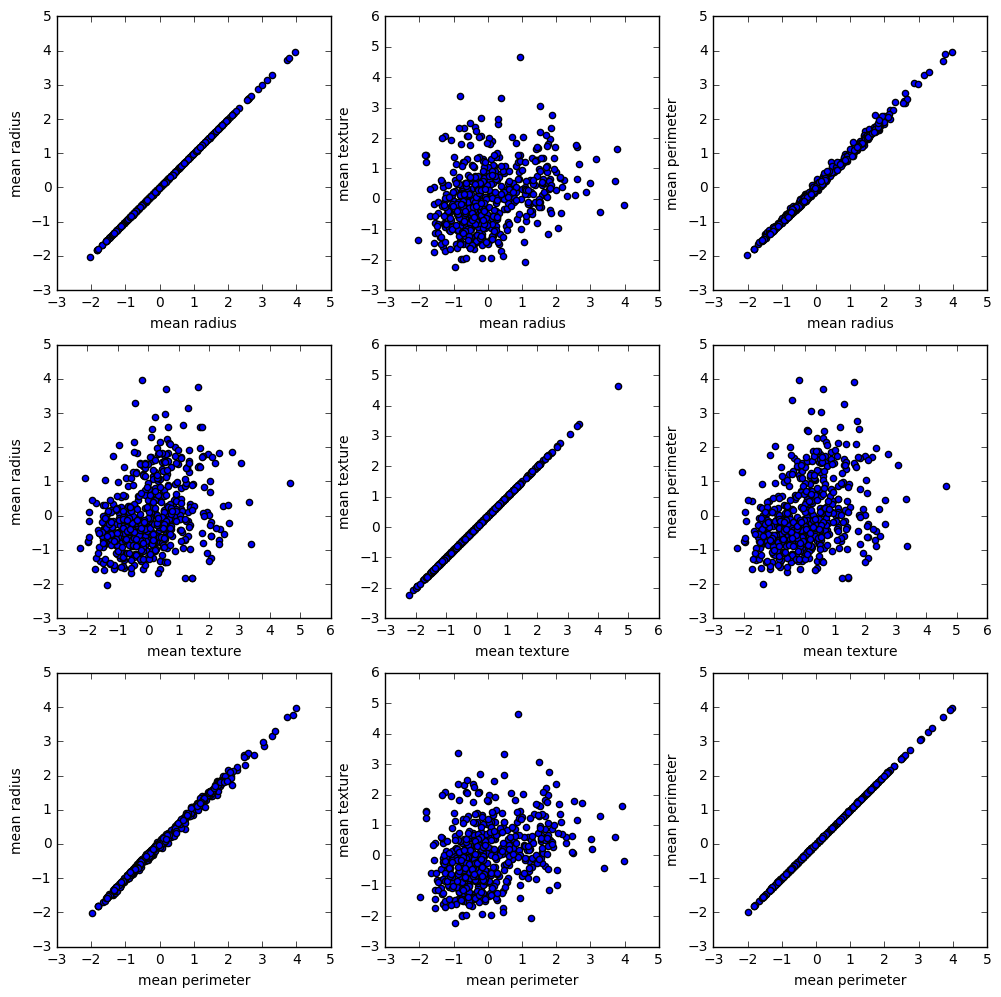

In [7]:
nrows = 3
fig, axes = plt.subplots(nrows, 3,figsize=(12,12))
print("Cancer Scatter Plots - Left Quadrant")
count = 0
for row in axes:
    row[0].scatter(X[:,count],X[:,0])
    row[0].set_xlabel(cancer.feature_names[count])
    row[0].set_ylabel(cancer.feature_names[0])
    row[1].scatter(X[:,count],X[:,1])
    row[1].set_xlabel(cancer.feature_names[count])
    row[1].set_ylabel(cancer.feature_names[1])
    row[2].scatter(X[:,count],X[:,2])
    row[2].set_xlabel(cancer.feature_names[count])
    row[2].set_ylabel(cancer.feature_names[2])
    count+=1

## Decision Trees and Ensemble Learning 

### Decision Trees and Information Gain 

Alright, enough looking at the data. Let's actually do something. Let's train 3 different classifiers, one singleton and two ensemble classifiers. All 3 models are based on decision trees, which evaluate the training data and split each node according to the value of highest information gain. $$IG(X) = H(X) - H(X|y),$$ where $$H(X) = -\sum_i p(X_i)log_2(p(X_i)),$$ and $$H(X|y) = \sum_{i,j}p(X_i,y_j)log_2(\frac{p(X_i,y_j)}{p(y_j)}).$$ The motivation for this can be somewhat nebulous for those not familiar with information theory. Generally speaking, entropy is a measure of randomness, or multiplicity. It is also a measure of uncertainty. For example, maximal uncertainty occurs when all states are equally likely. Entropy moves to zero as the system approaches a single state. As a result, information gain is an attempt to quantify uncertainty in a random variable X with respect to variations in another random variable y. Intuitively, we want a situation where X is maximally uncertain, and X given y is maximally certain (i.e. we know a lot about X when investigating another random variable y).

### Bagging

Bagging refers to an ensemble technique where multiple weak learners are combined using a voting scheme to generate accurate predictions. The advantage of this technique is that it lowers variance, and therefore can be advantageous over a single, strong decision tree. The idea with bagging techniques is as follows:
<ol>
<li> Select L weak learners
<li> For i in {0,...,L}, train each weak decision tree on a subset of data (bootstrap sampling).
<li> Add the classifier to the ensemble
<li> When training is finished, make predictions based on the most likely state.
</ol>

### Boosting 

Boosting: Boosting refers to training a set of N weak learners; however, instead of randomly sampling with replacement, each new learner is trained in a biased fashion (i.e. newly sampled data is skewed in favor of classes that the previous tree missed). This can reduce bias in the system; however, overfitting is a risk with this technique. The idea with boosting techniques is as follows:
<ol>
<li> Set weights $w_i$ for each learner (1/N)
<li> Select L weak learners
<li> for i in {0,...,L}, train a learner based on the sampled weights.
<li> Update the sampled weights based on the loss $\epsilon_i = \sum_k w_k^i l_i^k$
<li> Here l_i represents a loss function, such as an exponential loss for AdaBoost
<li> You can choose, to ignore the results of the training set if the error is too high.
<li> Reinitialize the weights based on $\beta_i = \frac{1-\epsilon_i}{\epsilon_i}$.
</ol>

In [8]:
# Define Models
def DecTree(X,Y):
    clf = tree.DecisionTreeClassifier()
    scores = []
    kf = KFold(n_splits=5)
    for train_idx,test_idx in kf.split(X):
        X_train,Y_train = X[train_idx],Y[train_idx]
        X_test,Y_test = X[test_idx],Y[test_idx]
        clf.fit(X_train,Y_train)
        scores.append(clf.score(X_test,Y_test))
    print "Decision Tree | Average Score Accross {} Folds: {}".format(5,np.mean(scores))
    return clf

def RandFor(X,Y):
    clf = RandomForestClassifier(n_estimators=100)
    kf = KFold(n_splits=5)
    scores=[]
    for train_idx,test_idx in kf.split(X):
        X_train,Y_train = X[train_idx],Y[train_idx]
        X_test,Y_test = X[test_idx],Y[test_idx]
        clf.fit(X_train,Y_train)
        scores.append(clf.score(X_test,Y_test))
    print "Random Forest (Bagging) | Average Score Accross {} Folds: {}".format(5,np.mean(scores))
    return clf

def BoostTree(X,Y):
    clf = AdaBoostClassifier(n_estimators=100)
    kf = KFold(n_splits=5)
    scores=[]
    for train_idx,test_idx in kf.split(X):
        X_train,Y_train = X[train_idx],Y[train_idx]
        X_test,Y_test = X[test_idx],Y[test_idx]
        clf.fit(X_train,Y_train)
        scores.append(clf.score(X_test,Y_test))
    print "Boosted Trees (Boosting) | Average Score Accross {} Folds: {}".format(5,np.mean(scores))
    return clf

In [9]:
# Train Classifiers
dec_tree_clf = DecTree(X,Y)
rand_for_clf = RandFor(X,Y)
boost_tree_clf = BoostTree(X,Y)

Decision Tree | Average Score Accross 5 Folds: 0.905030274802
Random Forest (Bagging) | Average Score Accross 5 Folds: 0.957879211303
Boosted Trees (Boosting) | Average Score Accross 5 Folds: 0.963095792579


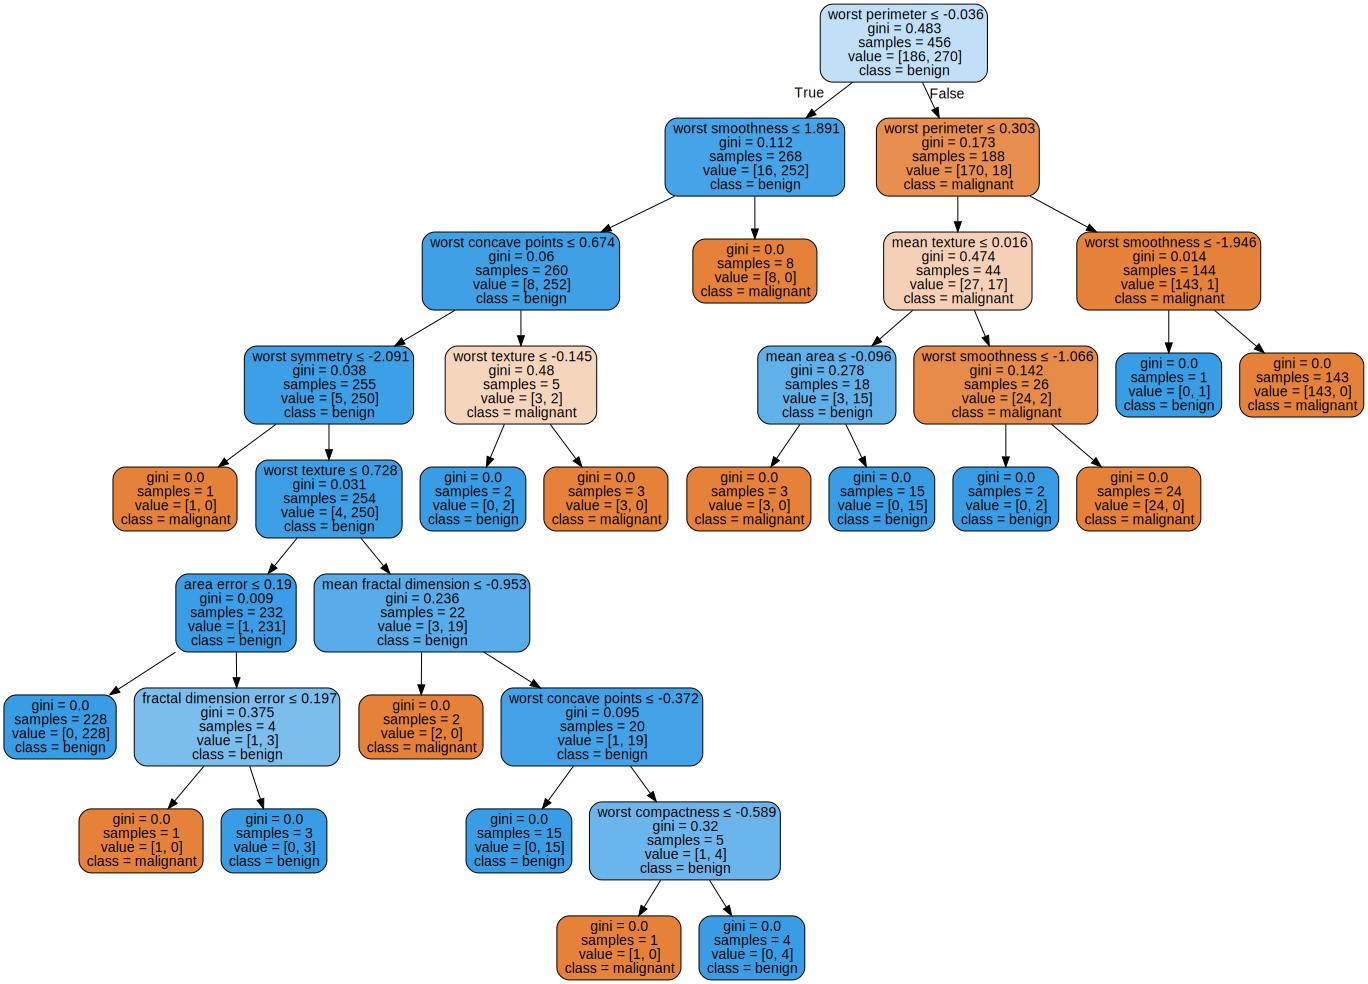

In [10]:
# View Decision Tree 
dot_data = tree.export_graphviz(dec_tree_clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("cancer") 
dot_data = tree.export_graphviz(dec_tree_clf, out_file=None, 
                         feature_names=cancer.feature_names,  
                         class_names=cancer.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [11]:
def DecTreePrune(X,Y):
    clf = tree.DecisionTreeClassifier(min_samples_split=20)
    scores = []
    kf = KFold(n_splits=5)
    for train_idx,test_idx in kf.split(X):
        X_train,Y_train = X[train_idx],Y[train_idx]
        X_test,Y_test = X[test_idx],Y[test_idx]
        clf.fit(X_train,Y_train)
        scores.append(clf.score(X_test,Y_test))
    print "Decision Tree | Average Score Accross {} Folds: {}".format(5,np.mean(scores))
    return clf

In [12]:
dec_tree_prune_clf = DecTreePrune(X,Y)

Decision Tree | Average Score Accross 5 Folds: 0.91561869275


In [13]:
from sklearn.svm import LinearSVC
def SVM(X,Y):
    clf = LinearSVC()
    scores = []
    kf = KFold(n_splits=5)
    for train_idx,test_idx in kf.split(X):
        X_train,Y_train = X[train_idx],Y[train_idx]
        X_test,Y_test = X[test_idx],Y[test_idx]
        clf.fit(X_train,Y_train)
        scores.append(clf.score(X_test,Y_test))
    print "Support Vector Machine | Average Score Accross {} Folds: {}".format(5,np.mean(scores))
    return clf 

In [14]:
svm_clf = SVM(X,Y)

Support Vector Machine | Average Score Accross 5 Folds: 0.970144387517


In [15]:
from sklearn.neural_network import MLPClassifier
def MLP(X,Y):
    clf = MLPClassifier()
    scores = []
    kf = KFold(n_splits=5)
    for train_idx,test_idx in kf.split(X):
        X_train,Y_train = X[train_idx],Y[train_idx]
        X_test,Y_test = X[test_idx],Y[test_idx]
        clf.fit(X_train,Y_train)
        scores.append(clf.score(X_test,Y_test))
    print "MultiLayered Perceptron | Average Score Accross {} Folds: {}".format(5,np.mean(scores))
    return clf 

In [16]:
mlp_clf = MLP(X,Y)

/usr/local/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MultiLayered Perceptron | Average Score Accross 5 Folds: 0.973653159447
